In [15]:
import pandas as pd
import numpy as np
import pymc

%matplotlib inline
import os
import math
import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image, HTML
import seaborn as sns
import matplotlib.pyplot as plt


In [16]:
df_16=pd.read_csv("C:\\Users\\Yannick\\Documents\\CoursENSAE\\Statapp\\F1_1617.csv")
df_15=pd.read_csv("C:\\Users\\Yannick\\Documents\\CoursENSAE\\Statapp\\F1_1516.csv")
df_14=pd.read_csv("C:\\Users\\Yannick\\Documents\\CoursENSAE\\Statapp\\F1_1415.csv")

df_15=df_15.drop(380)
df=df_15
df.head(5)

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,F1,07/08/15,Lille,Paris SG,0.0,1.0,A,0.0,0.0,D,...,1.63,25.0,0.75,2.11,2.03,1.85,1.80,7.58,3.91,1.58
1,F1,08/08/15,Bastia,Rennes,2.0,1.0,H,0.0,1.0,A,...,1.50,27.0,0.00,1.87,1.80,2.10,2.03,2.81,2.93,3.10
2,F1,08/08/15,Marseille,Caen,0.0,1.0,A,0.0,1.0,A,...,2.15,31.0,-1.00,2.00,1.92,1.95,1.90,1.57,4.13,7.04
3,F1,08/08/15,Montpellier,Angers,0.0,2.0,A,0.0,1.0,A,...,1.54,26.0,-0.50,1.84,1.78,2.13,2.06,1.84,3.42,5.42
4,F1,08/08/15,Nantes,Guingamp,1.0,0.0,H,0.0,0.0,D,...,1.44,25.0,-0.25,1.87,1.82,2.10,2.01,2.37,3.01,3.76


In [18]:
df = df.rename(columns={'HomeTeam':'home','AwayTeam':'away','FTHG': 'home_score', 'FTAG': 'away_score'})
df=df[['home','away','home_score', 'away_score']]


In [19]:
teams = df.home.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index
teams.head()

,team,i
0,Lille,0
1,Bastia,1
2,Marseille,2
3,Montpellier,3
4,Nantes,4


In [20]:
df = pd.merge(df, teams, left_on='home', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_home'}).drop('team', 1)
df = pd.merge(df, teams, left_on='away', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_away'}).drop('team', 1)
df.head()

,home,away,home_score,away_score,i_home,i_away
0,Lille,Paris SG,0.0,1.0,0,17
1,Bastia,Rennes,2.0,1.0,1,14
2,Marseille,Caen,0.0,1.0,2,12
3,Montpellier,Angers,0.0,2.0,3,11
4,Nantes,Guingamp,1.0,0.0,4,13


In [21]:
observed_home_goals = df.home_score.values
observed_away_goals = df.away_score.values
home_team = df.i_home.values
away_team = df.i_away.values
num_teams = len(df.i_home.unique())
num_games = len(home_team)

In [44]:
g = df.groupby('i_away')
att_starting_points = (g.away_score.mean())
g = df.groupby('i_home')
def_starting_points = (g.away_score.mean())

In [167]:
#hyperpriors
home = pymc.Lognormal('home', 1, 1, value=1)
# a_att = pymc.Gamma('a_att', 1, 1, value=1)
# a_def = pymc.Gamma('a_def', 1, 1, value=1)
# b_att = pymc.Gamma('b_att', 1, 1, value=1)
# b_def = pymc.Gamma('b_def', 1, 1, value=1)

mu_att=pymc.Normal('mu_att', 0, 0.001,value=10)
mu_def=pymc.Normal('mu_def', 0, 0.001,value=10)
tau_att = pymc.Gamma('tau_att', 1, 1, value=10)
tau_def = pymc.Gamma('tau_def', 1, 1, value=10)
#intercept = pymc.Lognormal('intercept', 1, 1, value=1)

#team-specific parameters
atts_star = pymc.Lognormal("atts_star", 
                        mu=mu_att, 
                        tau=tau_att, 
                        size=num_teams, 
                        value=att_starting_points.values)
defs_star = pymc.Lognormal("defs_star", 
                        mu=mu_def, 
                        tau=tau_def, 
                        size=num_teams, 
                        value=def_starting_points.values) 

# trick to code the sum to zero contraint
@pymc.deterministic
def atts(atts_star=atts_star):
    atts = atts_star.copy()
    atts = atts / np.sum(atts_star) * num_teams
    return atts

@pymc.deterministic
def defs(defs_star=defs_star):
    defs = defs_star.copy()
    #defs = defs / np.sum(defs_star) * num_teams
    return defs

@pymc.deterministic
def home_theta(home_team=home_team, 
               away_team=away_team, 
               home=home, 
               atts=atts, 
               defs=defs, 
               intercept=intercept): 
    return (home *
                  atts[home_team] * 
                  defs[away_team])
  
@pymc.deterministic
def away_theta(home_team=home_team, 
               away_team=away_team, 
               home=home, 
               atts=atts, 
               defs=defs, 
               intercept=intercept): 
    return ( atts[away_team] *  
                  defs[home_team])   


home_goals = pymc.Poisson('home_goals', 
                          mu=home_theta, 
                          value=observed_home_goals, 
                          observed=True)
away_goals = pymc.Poisson('away_goals', 
                          mu=away_theta, 
                          value=observed_away_goals, 
                          observed=True)


mcmc = pymc.MCMC([home, #intercept, #tau_att, tau_def, 
                  mu_att,mu_att, tau_def, tau_def,
                  home_theta, away_theta, 
                  atts_star, defs_star, atts, defs, 
                  home_goals, away_goals])
map_ = pymc.MAP( mcmc )
map_.fit()
mcmc.sample(200000, 40000, 20)

 [-----------------100%-----------------] 200000 of 200000 complete in 199.9 sec

Plotting defs_0
Plotting defs_1
Plotting defs_2
Plotting defs_3
Plotting defs_4
Plotting defs_5
Plotting defs_6
Plotting defs_7
Plotting defs_8
Plotting defs_9
Plotting defs_10
Plotting defs_11
Plotting defs_12
Plotting defs_13
Plotting defs_14
Plotting defs_15
Plotting defs_16
Plotting defs_17
Plotting defs_18
Plotting defs_19


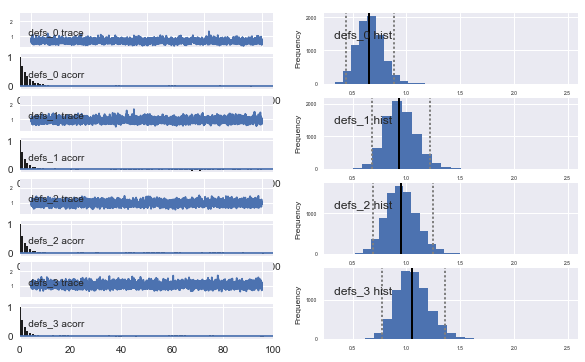

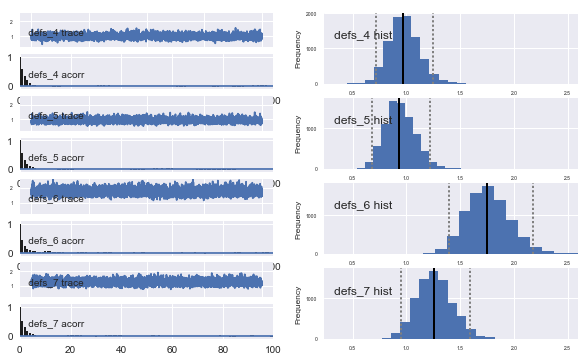

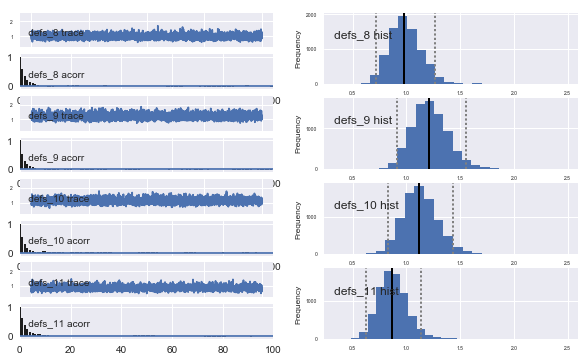

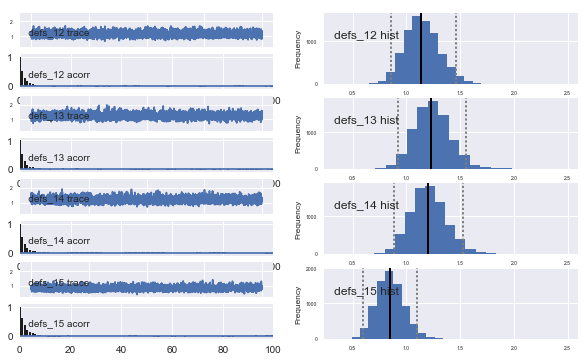

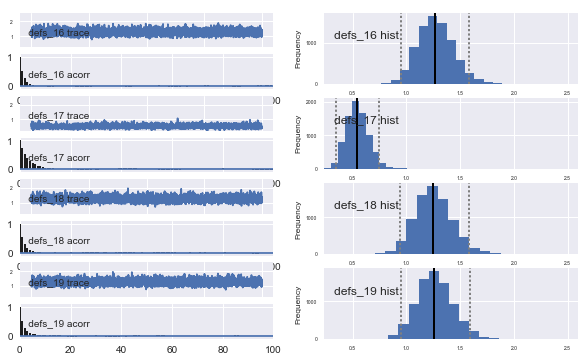

In [168]:
pymc.Matplot.plot(defs)

Plotting home


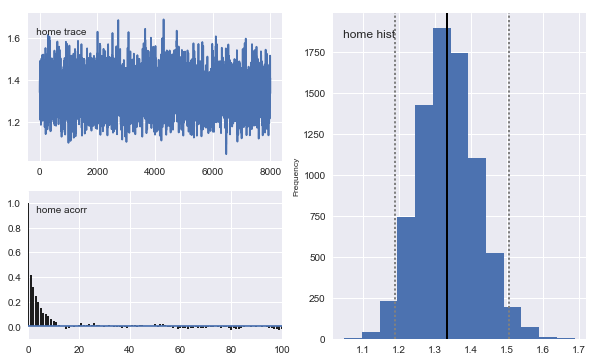

In [169]:
pymc.Matplot.plot(home)

Plotting atts_0
Plotting atts_1
Plotting atts_2
Plotting atts_3
Plotting atts_4
Plotting atts_5
Plotting atts_6
Plotting atts_7
Plotting atts_8
Plotting atts_9
Plotting atts_10
Plotting atts_11
Plotting atts_12
Plotting atts_13
Plotting atts_14
Plotting atts_15
Plotting atts_16
Plotting atts_17
Plotting atts_18
Plotting atts_19


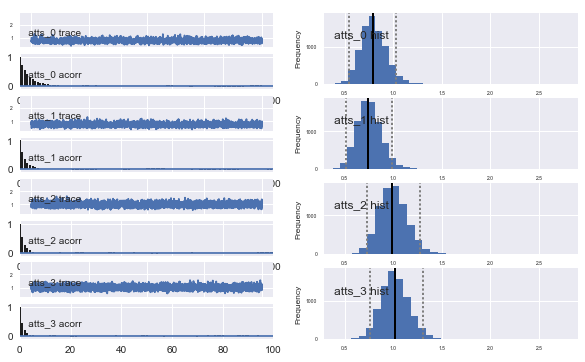

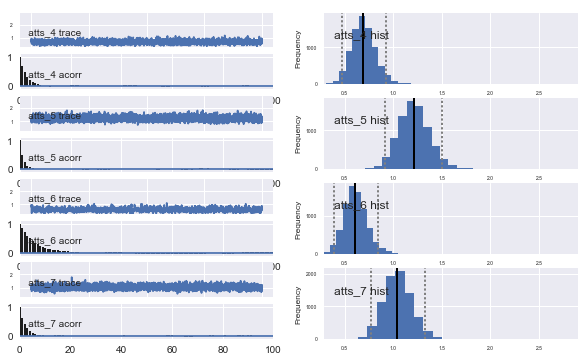

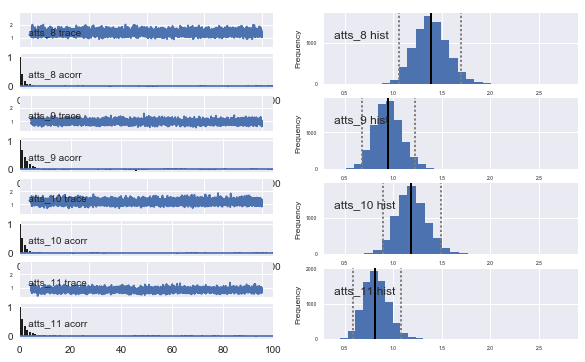

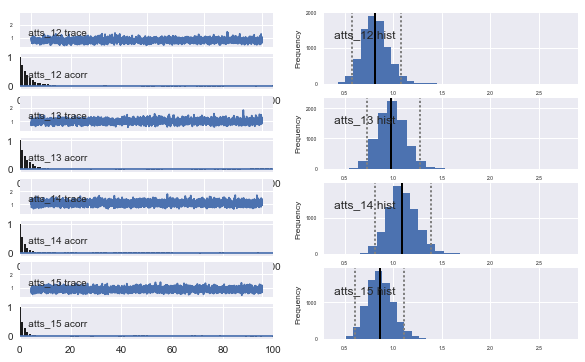

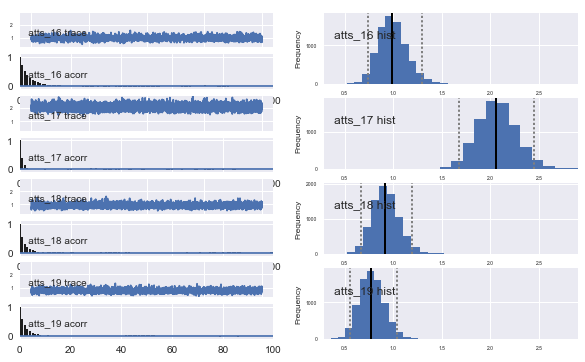

In [170]:
pymc.Matplot.plot(atts)

# Results 

In [88]:
def points(x,y):
    return [(x>y)*3+(x==y),(x<y)*3+(x==y)]

import scipy.stats as ss
df[['home_points','away_points']]=pd.DataFrame(np.transpose(points(df['home_score'],df['away_score'])))
total_scores=df.groupby('away')['away_points'].sum()+df.groupby('home')['home_points'].sum()
ranking=pd.DataFrame(columns=['teams','points'])
ranking['team']=total_scores.keys()
ranking['points']=total_scores.values
ranking['final_rank']=ss.rankdata(-total_scores)

def get_season_outcome(x):
    if x.final_rank<3:
        return 'champs_league'
    elif x.final_rank<5:
        return 'europa_league'
    elif x.final_rank>17: 
        return 'relegation'
    else:
        return ''

ranking['QR']=ranking.apply(get_season_outcome,axis=1)


In [173]:
df_observed =ranking
df_observed.loc[df_observed.QR.isnull(), 'QR'] = ''
df_teams_paras = pd.DataFrame({'mean_att': atts.stats()['mean'],
                            'mean_def': defs.stats()['mean'],
                            'std_att': atts.stats()['standard deviation'],
                            'std_def': defs.stats()['standard deviation']}, 
                      index=teams.team.values)

# fig, ax = plt.subplots(figsize=(12,8))
# for outcome in ['champs_league', 'relegation', 'europa_league', '']:
#     ax.plot(df_avg.avg_att[df_avg.QR == outcome], 
#             df_avg.avg_def[df_avg.QR == outcome], 'o', label=outcome)
    
# for label, x, y in zip(df_avg.team.values, df_avg.avg_att.values, df_avg.avg_def.values):
#     ax.annotate(label, xy=(x,y), xytext = (-5,5), textcoords = 'offset points')
# ax.set_title('Attack vs Defense avg effect: 15-16 Ligue 1')
# ax.set_xlabel('Avg attack effect')
# ax.set_ylabel('Avg defense effect')
# ax.legend()

In [183]:
print(df_teams_paras)
import pickle
from os import open
pickle.dumps( df_teams_paras, open( "df_teams_paras_lognormal.p", "wb" ) )




              mean_att  mean_def   std_att   std_def
Lille         0.795075  0.659583  0.123582  0.115802
Bastia        0.749707  0.945227  0.122704  0.139644
Marseille     0.997107  0.954569  0.139913  0.140865
Montpellier   1.020244  1.057939  0.140055  0.150287
Nantes        0.693136  0.977238  0.118159  0.138047
Nice          1.214570  0.941376  0.152441  0.138364
Troyes        0.613627  1.760037  0.116120  0.201607
Bordeaux      1.047725  1.263070  0.142834  0.165593
Lyon          1.390487  0.989641  0.165918  0.142890
Toulouse      0.946199  1.217630  0.137779  0.162712
Monaco        1.189842  1.127762  0.153172  0.155808
Angers        0.822564  0.872330  0.126278  0.133838
Caen          0.813951  1.145680  0.131126  0.156153
Guingamp      0.983022  1.235127  0.140806  0.161656
Rennes        1.092836  1.205970  0.146800  0.163674
St Etienne    0.865533  0.849158  0.129372  0.129442
Lorient       0.991672  1.271862  0.142670  0.163648
Paris SG      2.066592  0.544212  0.198338  0.

TypeError: an integer is required (got type str)

In [180]:
# df_other_paras=pd.DataFrame([[home.stats()['mean'],intercept.stats()['mean']],
#                              [home.stats()['standard deviation'],intercept.stats()['standard deviation']]],
#                            index=['home','intercept'],
#                            columns=['mean','std'])

print(home.stats()['mean'],home.stats()['standard deviation'])


1.33691311391 0.0813598559092


# Goal distribution for every game

In [93]:
#Functions useful for later
def get_pred(probas):
    i=np.argmax(probas)
    return i[:-6]

def get_outcome(results):
    if results['home_score'] > results['away_score']:
        return 'home' 
    elif results['home_score'] < results['away_score']:
        return 'away'
    else: 
        return 'draw'
    

In [110]:
from scipy import stats

possible_goals=np.arange(8)
def get_distributions(home_theta,away_theta,idx_game):
    home_theta.trace()
    home_goals_pdf=np.array([stats.poisson.pmf(possible_goals,mu) 
                               for mu in home_theta.trace()[:,idx_game]]).mean(axis=0)
    away_goals_pdf=np.array([stats.poisson.pmf(possible_goals,mu) 
                               for mu in away_theta.trace()[:,idx_game]]).mean(axis=0)
    return (home_goals_pdf,away_goals_pdf)

def get_mean_goals(home_theta,away_theta,idx_game):
    (home_goals_pdf,away_goals_pdf)=get_distributions(home_theta,away_theta,idx_game)
    
    #Expectation of goals
    mean_home=(home_goals_pdf*possible_goals).sum()
    mean_away=(away_goals_pdf*possible_goals).sum()
    return (mean_home,mean_away) 


def distrib_to_probas(home_goals_pdf,away_goals_pdf):
    #we compute the strict cdf
    home_goals_cdf=np.array([np.sum([home_goals_pdf[:i]]) 
                                    for i in possible_goals])
    away_goals_cdf=np.array([np.sum([away_goals_pdf[:i]]) 
                                    for i in possible_goals])
    proba_home=0
    for i in np.arange(1,len(possible_goals)):
        proba_home+=home_goals_pdf[i]*away_goals_cdf[i]
        
    proba_draw=0
    for i in possible_goals:
        proba_draw+=home_goals_pdf[i]*away_goals_pdf[i]
    
    proba_away=0
    for i in np.arange(1,len(possible_goals)):
        proba_away+=away_goals_pdf[i]*home_goals_cdf[i]

    #TODO : check proba_home+proba_draw+proba_away=1
    return([proba_home,proba_draw,proba_away])


def get_outcome_probas(home_theta,away_theta,idx_game):
    (home_goals_pdf,away_goals_pdf)=get_distributions(home_theta,away_theta,idx_game)
    
    return(distrib_to_probas(home_goals_pdf,away_goals_pdf))
                    

In [153]:
df_results = distrib.reindex(columns=['home_distrib','away_distrib','home','away','home_proba','draw_proba','away_proba'])
df_results[['home','away']]=df[['home','away']]
df_results[['home_distrib','away_distrib']]=distrib[[0,1]]

for i,value in enumerate(['home_proba','draw_proba','away_proba']):
    df_results[value]=distrib.apply(lambda x : distrib_to_probas(x[0],x[1])[i],axis=1)

df_results['prediction']=df_results.apply(lambda x: get_pred(x[-3:]),axis=1)
df_results["game_outcome"]=df.apply(get_outcome,axis=1)
df_results.head()

,home_distrib,away_distrib,home,away,home_proba,draw_proba,away_proba,prediction,game_outcome
0,"[0.625170131834, 0.288419381506, 0.07161925599...","[0.292230881288, 0.34965850423, 0.21858883712,...",Lille,Paris SG,0.143189,0.300469,0.556221,away,away
1,"[0.304698796155, 0.352133400251, 0.21300265541...","[0.367434120301, 0.360056495406, 0.18392027358...",Bastia,Rennes,0.405715,0.284356,0.309800,home,home
2,"[0.226419736237, 0.326413083591, 0.24466314471...","[0.467481685911, 0.348852086267, 0.13658514658...",Marseille,Caen,0.547919,0.258320,0.193366,home,away
3,"[0.322200344242, 0.355568946399, 0.20517915769...","[0.422354532737, 0.356921133887, 0.15768734762...",Montpellier,Angers,0.421457,0.299666,0.278797,home,away
4,"[0.329046075643, 0.356614804968, 0.20206230451...","[0.385960347128, 0.359641342523, 0.17510972516...",Nantes,Guingamp,0.393679,0.295770,0.310471,home,home


In [154]:
df_results.groupby(['game_outcome','prediction']).size()

game_outcome  prediction
away          away           49
              draw            4
              home           59
draw          away           31
              draw            2
              home           75
home          away           23
              draw            4
              home          133
dtype: int64

In [155]:
df_results['game_outcome'].value_counts()/380

home    0.421053
away    0.294737
draw    0.284211
Name: game_outcome, dtype: float64

Bad prediction of draws: not enough draws predicted.Draw probabilities are probably underestimated.

Too many home victories. Home probabilities are probably overestimated.

Prediction accuracy on training data: 48%
Benchmark: most represented outcome: 42% 

Let's have a look at the probabilities that the bookmakers have used.

In [156]:
#Induced probabilities
induced_probas=df_15[['PSH','PSD','PSA']].apply(lambda x: [1/(x[0]),1/(x[1]),1/(x[2])],axis=1)
#Sum of induced probas
print(induced_probas.sum(axis=1).head())
#Mean of sum of induced probas
print('\n')
print(induced_probas.sum(axis=1).head().mean())

0    1.021213
1    1.025962
2    1.022656
3    1.024016
4    1.025465
dtype: float64


1.02386235521


In [52]:
#The probas seem to always sum up to 1.02.

# A few histograms

In [141]:
def distribution_plot(home_team,away_team):

    data_to_hist=distrib[distrib['home']==home_team][distrib['away']==away_team]
    obs_vars=['home_score','away_score']
    variables=['home_goals','away_goals']
    titles=[home_team,away_team]
    
    f,a = plt.subplots(1,2)
    a = a.ravel()
    for idx,ax in enumerate(a):
        ax.bar(range(len(data_to_hist.iloc[0,idx])),data_to_hist.iloc[0,idx])
        ax.set_title(titles[idx])
#        obs_score=df[df['home']==home_team][df['away']==away_team][obs_vars[idx]]
#        ax.plot([obs_score, obs_score], ax.get_ylim())
#        ax.annotate('Observed score: %s' % obs_score, xy=(obs_score + 0.1, ax.get_ylim()[1]-10))
    plt.tight_layout()

In [ ]:
distribution_plot("Lyon","Bastia")